In [2]:
import wandb
import ast
import argparse
import os
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    WaitingTime,
    ComplexLine
)

import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import (
    HeteroConv,
    GCNConv,
    SAGEConv,
    TransformerConv,
    HGTConv,
)
from torch.nn import Linear
from wandb.integration.sb3 import WandbCallback
import networkx as nx
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [44]:
dataset = torch.load('../data/complex_line_graph_n_assemblies5_waiting_time5.pt', weights_only=False)


In [59]:
len(dataset['graph'])

4000

/tmp/ipykernel_860698/579061051.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


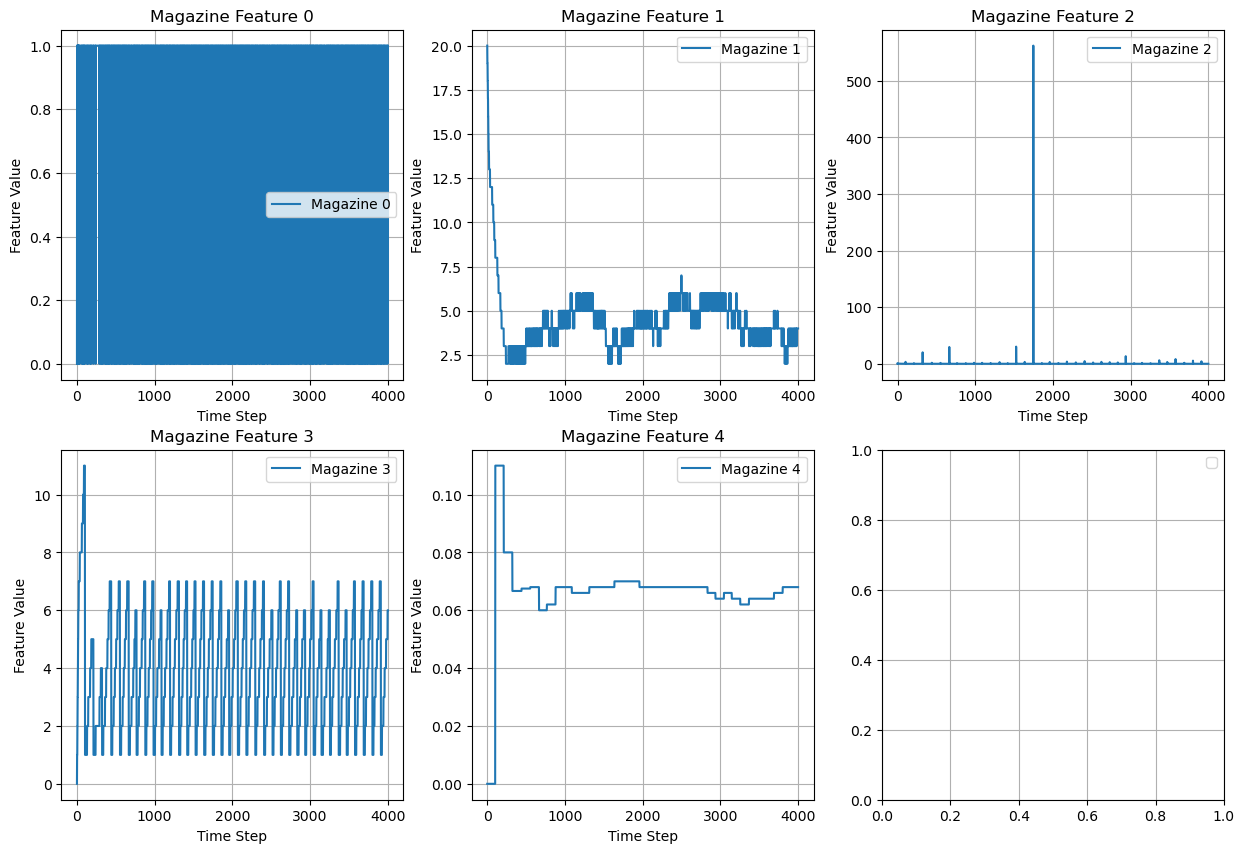

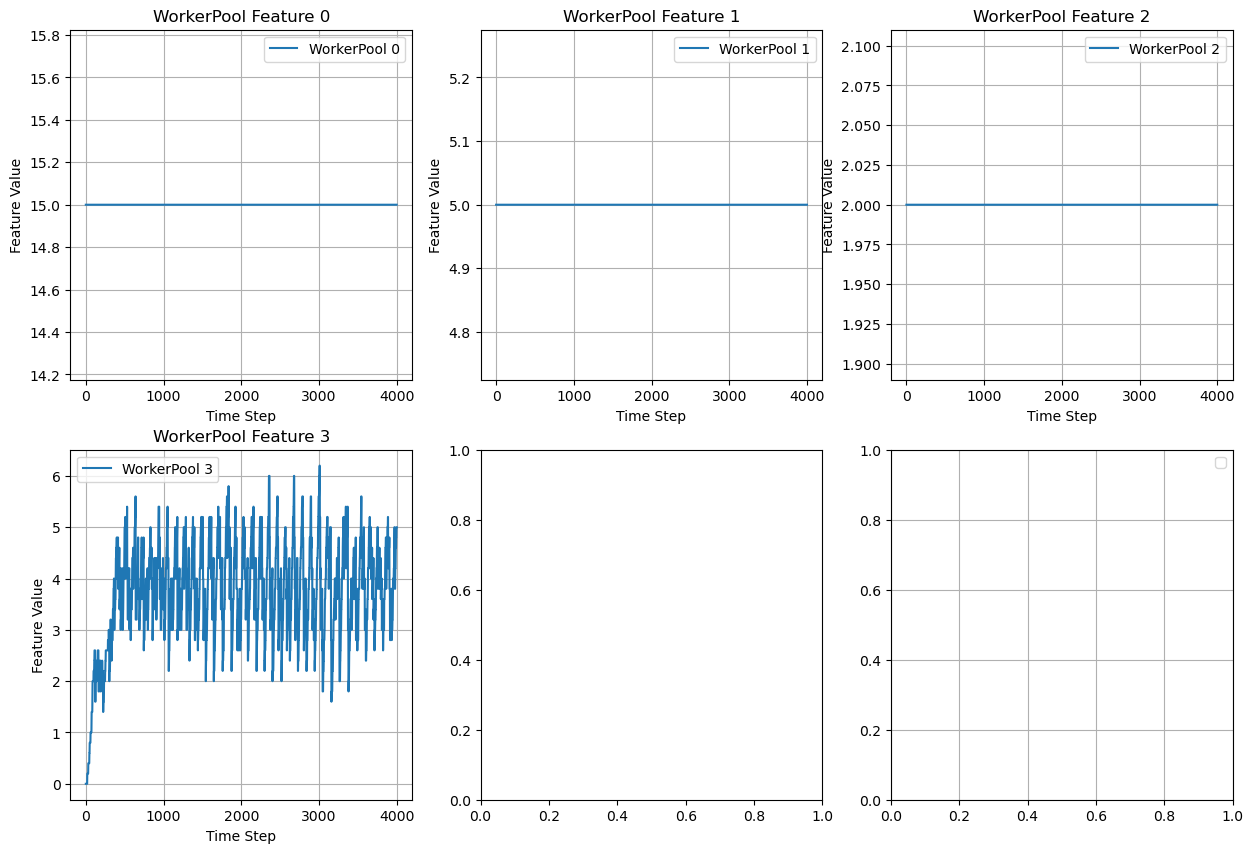

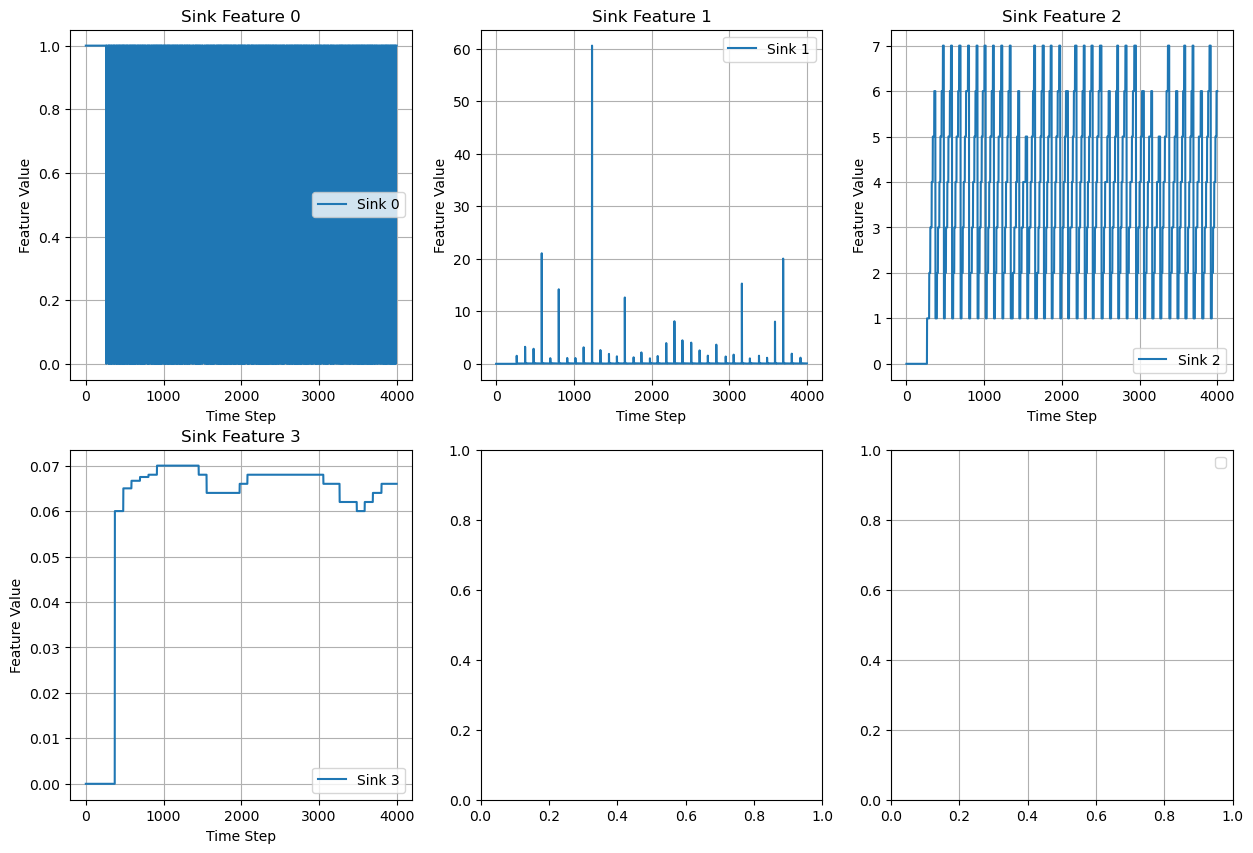

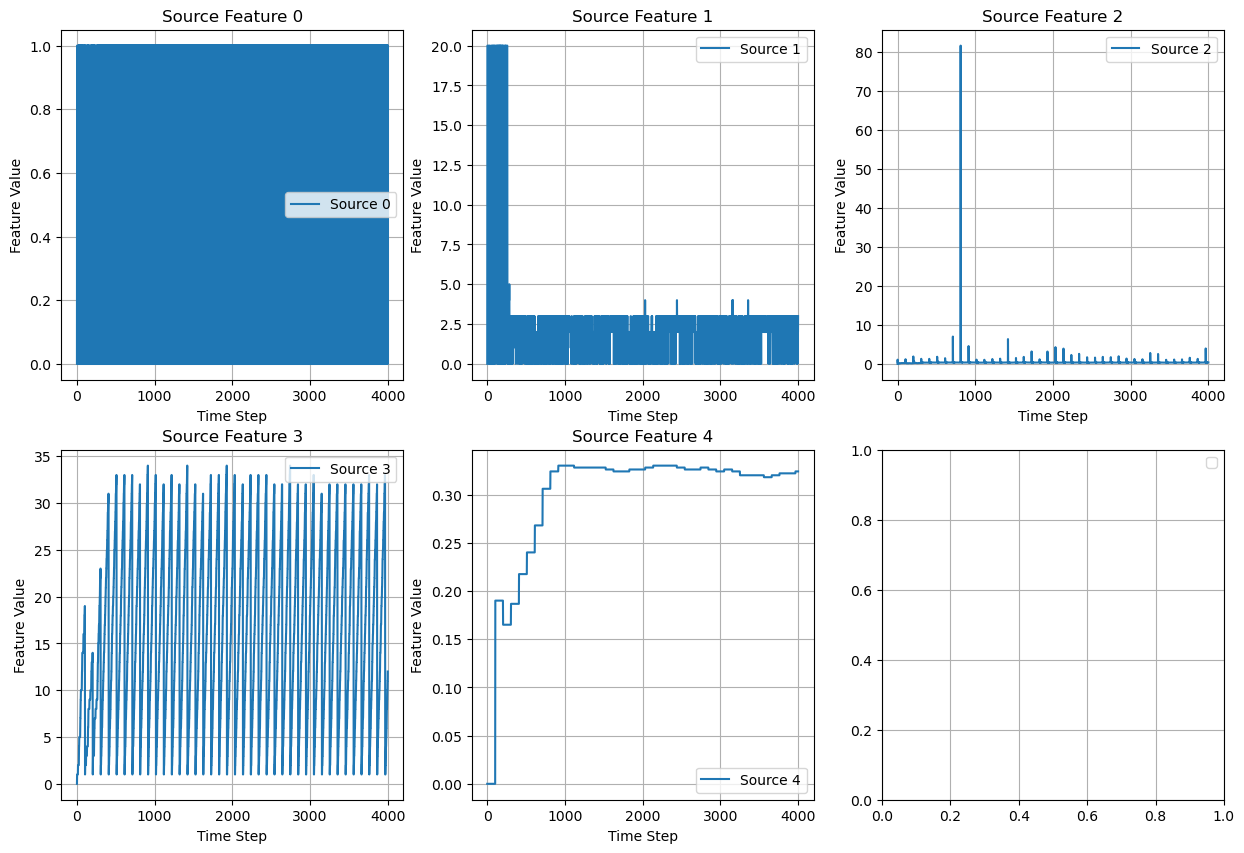

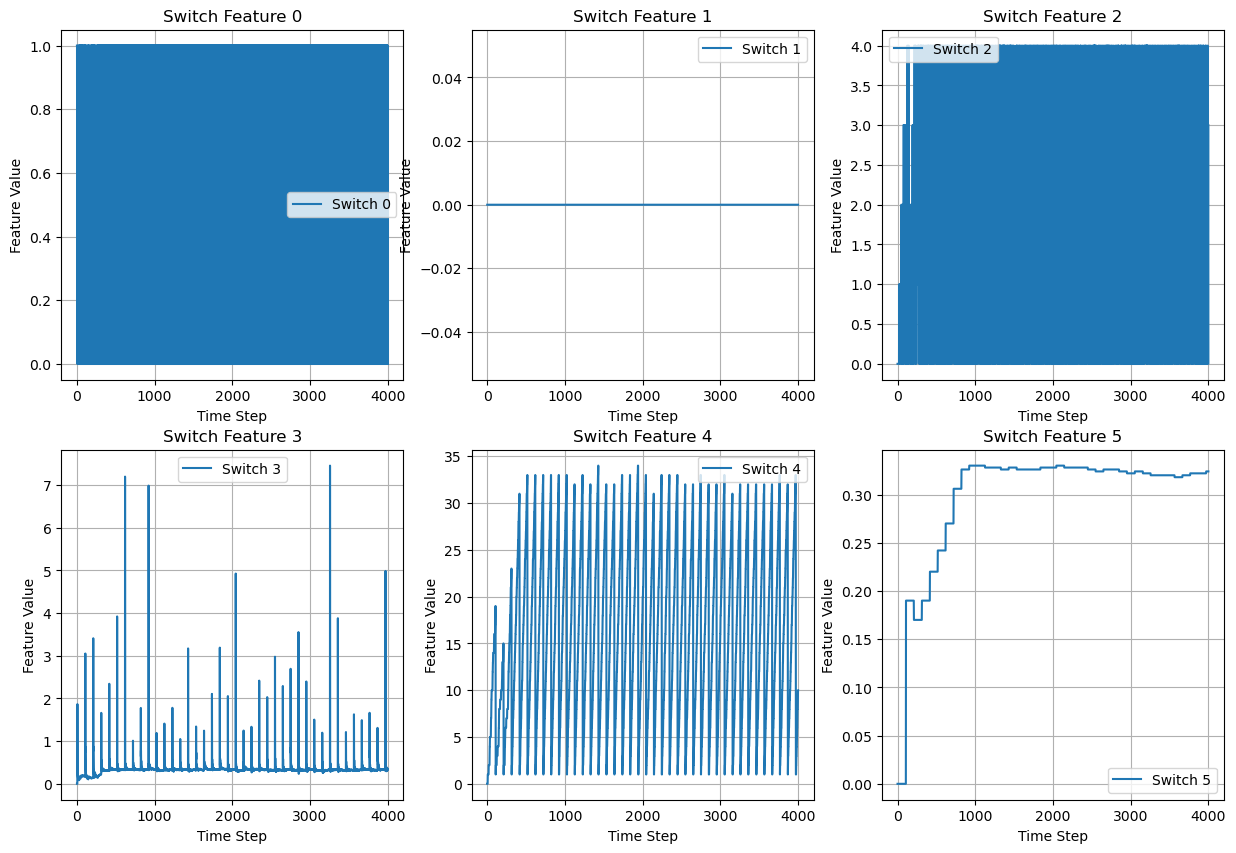

IndexError: index 6 is out of bounds for axis 0 with size 6

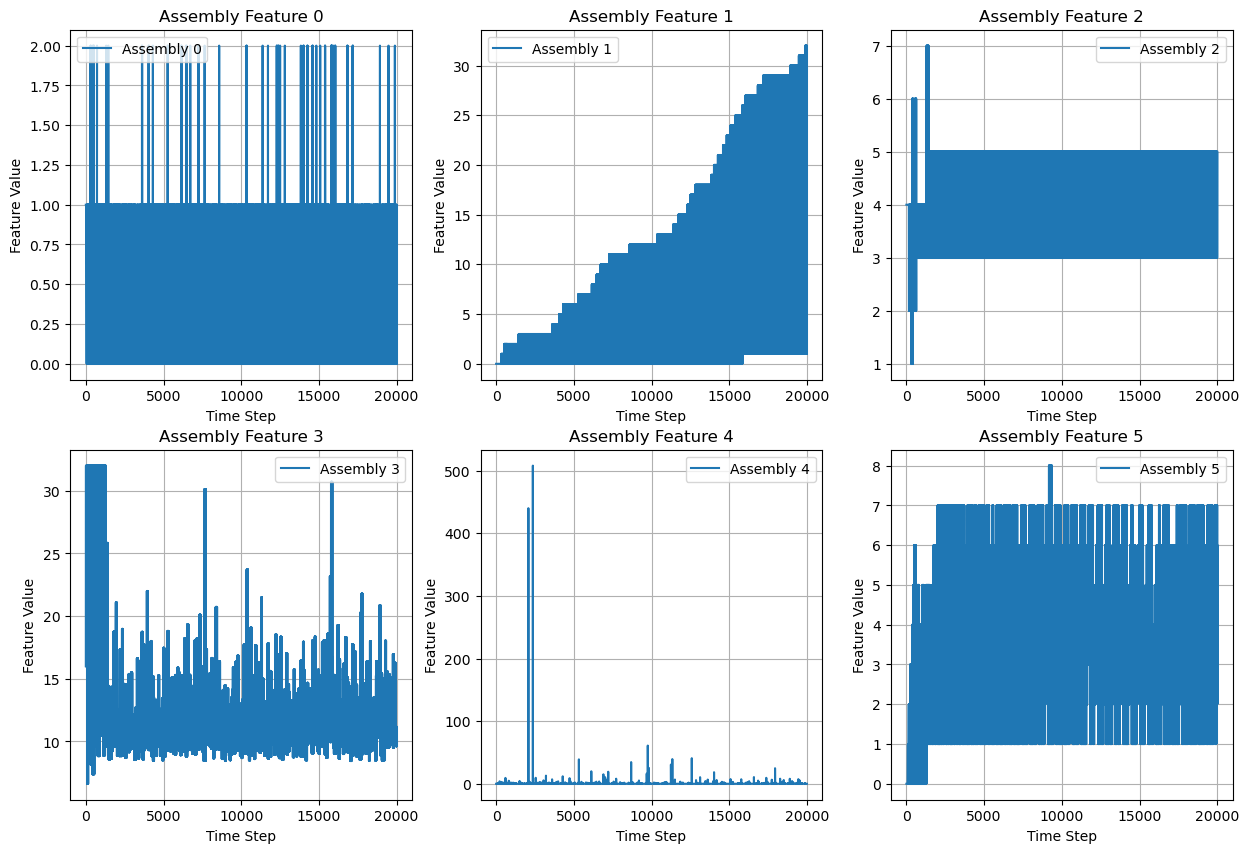

In [46]:
# check_type = 'Magazine'

for check_type in dataset['graph'][0].node_types:
    switch_data = dataset['graph'][0][check_type].x # Start with the first graph's data
    for i in range(1, len(dataset['graph'])):
        switch_data = torch.cat((switch_data, dataset['graph'][i][check_type].x), dim=0)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.flatten()  # Flatten to make indexing easier
    for i in range(switch_data.shape[1]):
        axs[i].plot(switch_data[:, i].cpu().numpy(), label=f'{check_type} {i}')
        axs[i].set_title(f'{check_type} Feature {i}')
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Feature Value')
        axs[i].grid(True)
        axs[i].legend()
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
(dataset['graph'][0]['Assembly'].x.shape)

torch.Size([5, 7])

In [31]:
dataset['graph'][i]['Assembly'].x[0].shape


torch.Size([7])

/tmp/ipykernel_860698/2578170875.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


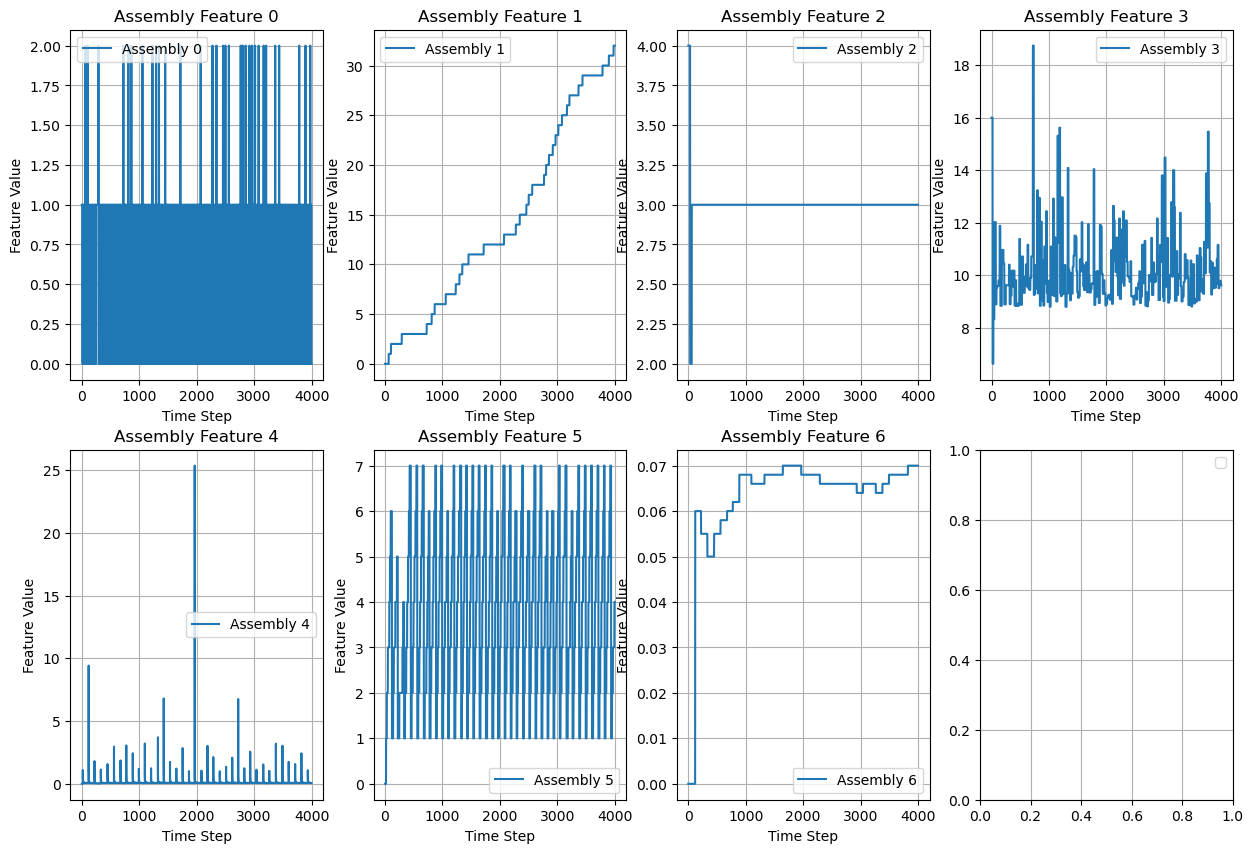

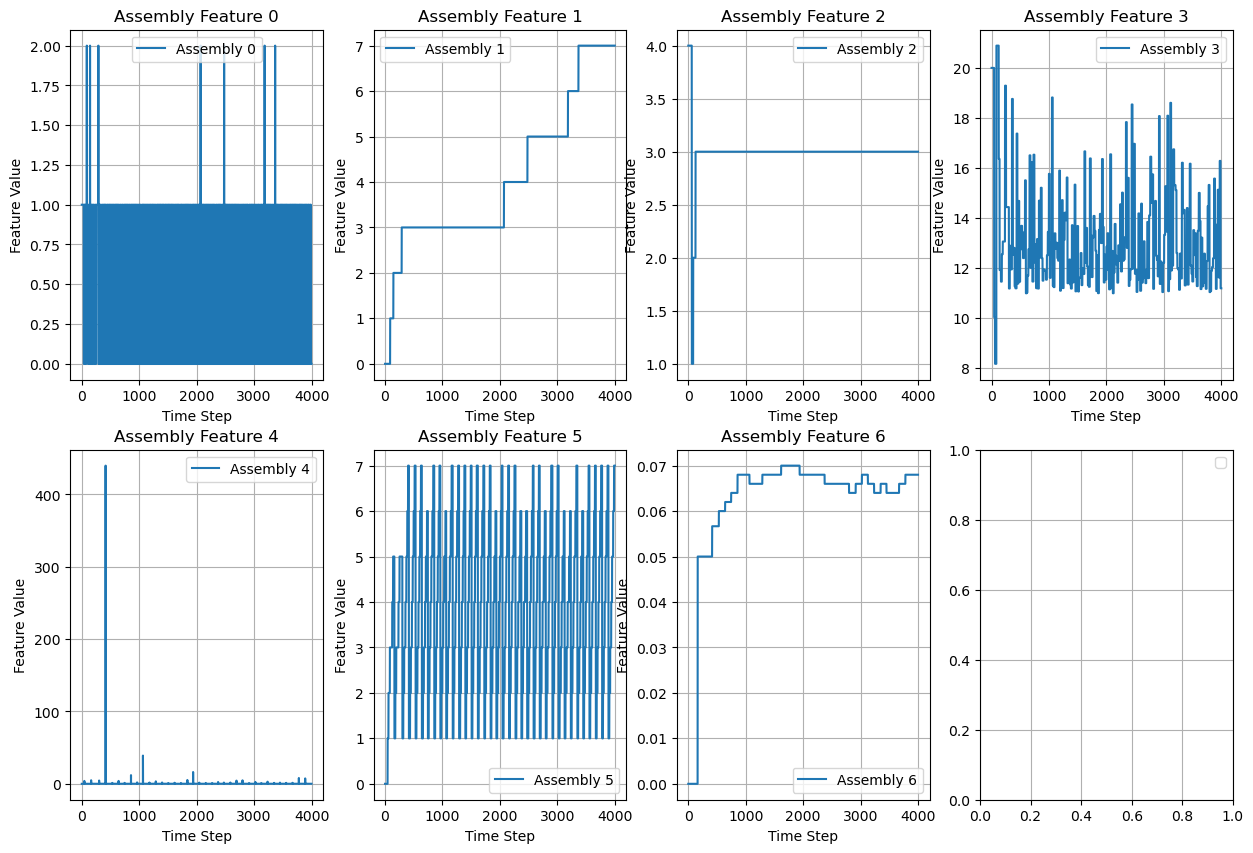

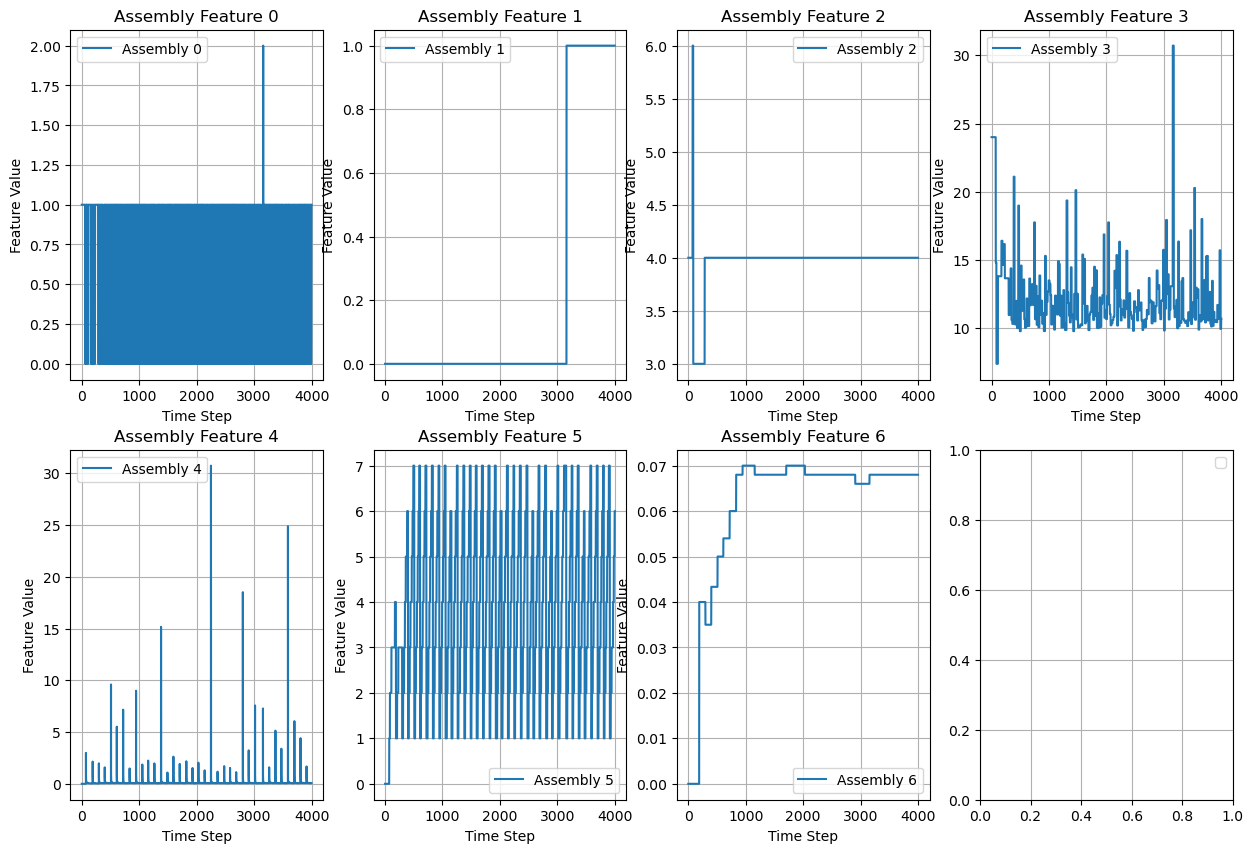

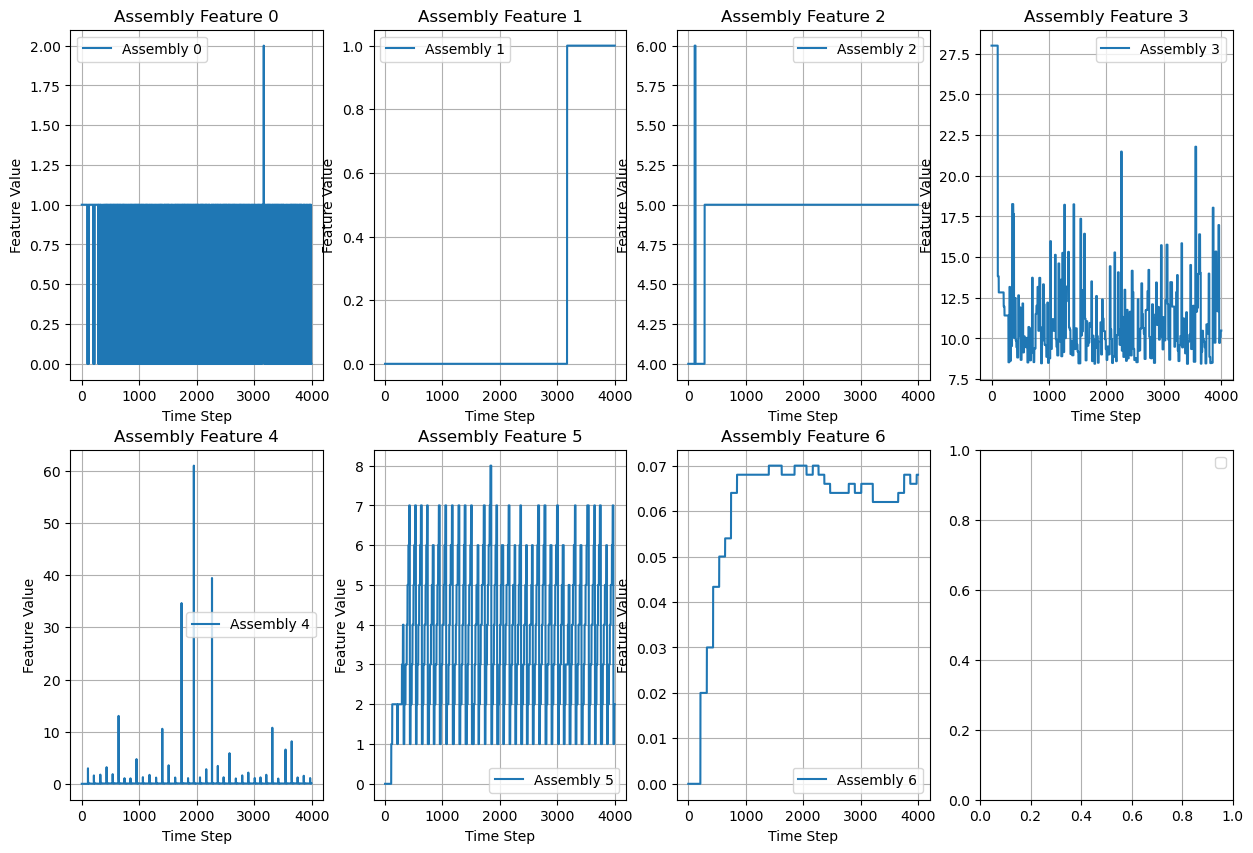

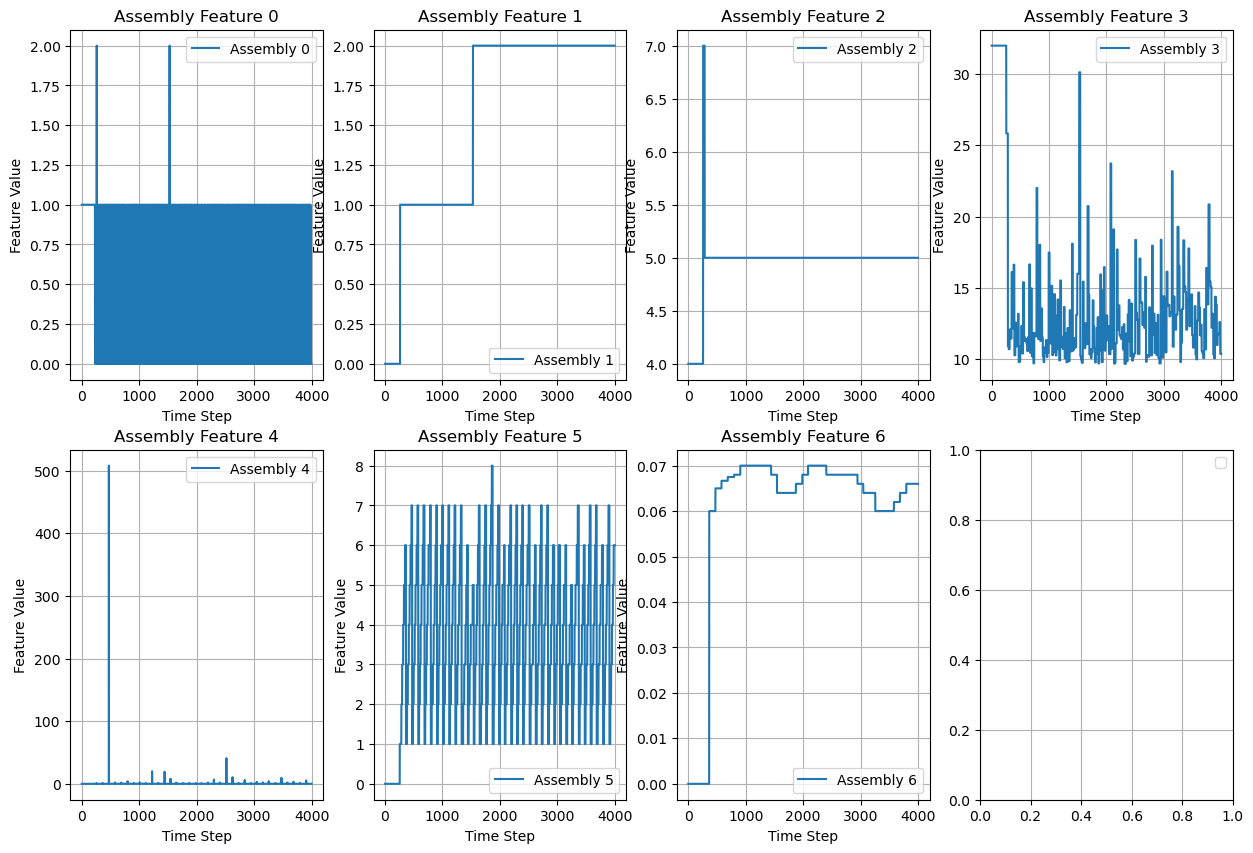

In [47]:
for j in range(dataset['graph'][0]['Assembly'].x.shape[0]):
    switch_data = dataset['graph'][0]['Assembly'].x[j].unsqueeze(0) # Start with the first graph's data
    for i in range(1, len(dataset['graph'])):
        switch_data = torch.cat((switch_data, dataset['graph'][i]['Assembly'].x[j].unsqueeze(0)), dim=0)
        # print(f"Shape of switch_data for Assembly {j}: {switch_data.shape}")

    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    axs = axs.flatten()  # Flatten to make indexing easier
    for i in range(switch_data.shape[1]):
        axs[i].plot(switch_data[:, i].cpu().numpy(), label=f'{check_type} {i}')
        axs[i].set_title(f'{check_type} Feature {i}')
        axs[i].set_xlabel('Time Step')
        axs[i].set_ylabel('Feature Value')
        axs[i].grid(True)
        axs[i].legend()
    plt.legend()
    plt.grid(True)
    plt.show()

In [185]:
switch_data.shape

torch.Size([800, 6])

In [168]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# loader = ChickenpoxDatasetLoader()

# dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

AttributeError: 'dict' object has no attribute 'snapshot_count'

In [164]:
dataset[12]

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

In [39]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Add nodes
    for node_type in data.node_types:
        for i in range(data[node_type].num_nodes):
            G.add_node((node_type, i), node_type=node_type)

    # Add edges with types
    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        for src, dst in zip(edge_index[0], edge_index[1]):
            G.add_edge((src_type, int(src)), (dst_type, int(dst)), key=rel_type, rel_type=rel_type)

    return G


In [40]:
def create_manufacturing_layout(G):
    """Create a hierarchical layout for manufacturing systems"""
    pos = {}
    
    # Define hierarchy levels
    levels = {
        'Source': 0,
        'Magazine': 1, 
        'Assembly': 2,
        'Switch': 3,
        'Sink': 4,
        'WorkerPool': 1.5,  # Between magazine and assembly
        'Worker': 1.5
    }
    
    # Group nodes by type
    node_groups = {}
    for node in G.nodes():
        node_type = node[0]
        if node_type not in node_groups:
            node_groups[node_type] = []
        node_groups[node_type].append(node)
    
    # Position nodes by level and spread horizontally
    for node_type, nodes in node_groups.items():
        level = levels.get(node_type, 2)
        for i, node in enumerate(nodes):
            x = i - len(nodes)/2  # Center horizontally
            y = -level  # Negative to flow top to bottom
            pos[node] = (x, y)
    
    return pos

In [ ]:
# line = ComplexLine(use_graph_as_states=True, n_workers = 3)
# data = line._graph_states
# data

In [ ]:
# from torch_geometric.datasets import OGB_MAG

# dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
# data = dataset[0]
# data

In [ ]:
import matplotlib.pyplot as plt
# data = data['graph'][0]
G = hetero_to_networkx(data)

# Layout
# pos = nx.spring_layout(G, seed=42)
pos = create_manufacturing_layout(G) 
pos = nx.shell_layout(G)  
# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral',
    'WorkerPool': 'lightblue',
    'Magazine': 'lightgrey',
    'Worker': 'yellow',
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='WorkerPool', markerfacecolor='lightblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Magazine', markerfacecolor='lightgrey', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Worker', markerfacecolor='yellow', markersize=10)
])
plt.axis('off')
plt.show()


In [158]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv
from torch_geometric.data import HeteroData
from torch.nn import Linear
from torch_geometric.nn import HeteroConv, SAGEConv,TransformerConv, HGTConv


class GraphStatePredictor(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, data, context_window=5):
        super().__init__()
        self.context_window = context_window
        self.hidden_channels = hidden_channels
        self.data = data
        # Linear layers for each node type to project to hidden dimension
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            in_channels = data.x_dict[node_type].shape[1]
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)
        
        # HGT layers for processing individual graphs
        self.graph_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(), num_heads)
            self.graph_convs.append(conv)
        
        # Temporal transformer to process sequence of graph states
        self.temporal_transformer = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(
                d_model=hidden_channels,
                nhead=num_heads,
                dim_feedforward=hidden_channels * 4,
                batch_first=True
            ),
            num_layers=2
        )
        
        # Output projection for each node type
        self.output_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            out_features = data.x_dict[node_type].shape[1]
            self.output_dict[node_type] = Linear(hidden_channels, out_features)
    
    def encode_single_graph(self, x_dict, edge_index_dict):
        # Project node features to hidden dimension
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }
        
        # Apply HGT convolutions
        for conv in self.graph_convs:
            x_dict = conv(x_dict, edge_index_dict)
        
        return x_dict
    
    def forward(self, graph_sequence):
        """
        Args:
            graph_sequence: List of HeteroData objects representing graph states
        Returns:
            Predicted next graph state as dict of node type tensors
        """
        batch_size = len(graph_sequence)
        
        # Encode each graph in the sequence
        encoded_sequence = {}
        for node_type in self.data.node_types:
            encoded_sequence[node_type] = []
        
        for graph in graph_sequence:
            encoded_graph = self.encode_single_graph(graph.x_dict, graph.edge_index_dict)
            for node_type in self.data.node_types:
                encoded_sequence[node_type].append(encoded_graph[node_type])
        
        # Apply temporal transformer for each node type
        predictions = {}
        for node_type in self.data.node_types:
            # Stack temporal sequence: [seq_len, num_nodes, hidden_dim]
            node_sequence = torch.stack(encoded_sequence[node_type], dim=0)
            num_nodes = node_sequence.shape[1]
            
            # Reshape for transformer: [num_nodes, seq_len, hidden_dim]
            node_sequence = node_sequence.transpose(0, 1)
            
            # Apply temporal transformer to each node independently
            temporal_output = []
            for node_idx in range(num_nodes):
                node_temporal = node_sequence[node_idx].unsqueeze(0)  # [1, seq_len, hidden_dim]
                transformed = self.temporal_transformer(node_temporal)
                temporal_output.append(transformed[:, -1, :])  # Take last timestep
            
            temporal_features = torch.cat(temporal_output, dim=0)  # [num_nodes, hidden_dim]
            
            # Project to output dimension
            predictions[node_type] = self.output_dict[node_type](temporal_features)
        
        return predictions
    

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, data):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            in_channels = data.x_dict[node_type].shape[1]
            self.lin_dict[node_type] = Linear(in_channels, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads)
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict


# model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3)

# # model = HGT(state.metadata())  # metadata = (node_types, edge_types)
# out = model(data.x_dict, data.edge_index_dict)

In [147]:
dataset = torch.load('../data/complex_line_graph_n_assemblies5_waiting_time5.pt', weights_only=False)

In [152]:
(dataset['Reward'])

132.8

In [119]:
# import os
# import glob
# # Get all .pt files in the data folder
# data_files = glob.glob('../data/*.pt')

# # Initialize list to store all datasets
# all_data_sets = []

# # Loop through each .pt file and load it
# for file_path in data_files:
#     try:
#         dataset = torch.load(file_path, weights_only=False)
#         all_data_sets.append({
#             'filename': os.path.basename(file_path),
#             'data': dataset
#         })
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")

# print(f"\nTotal datasets loaded: {len(all_data_sets)}")


Total datasets loaded: 28


In [137]:
num_indices = 3
random_indices = random.sample(range(len(all_data_sets)), num_indices)
random_indices

[5, 3, 6]

In [175]:

import torch.nn as nn
import random
import numpy as np

# Training parameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 16
sequence_length = 5
temporal_model = GraphStatePredictor(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, context_window=5, data=all_data_sets[0]['data']['graph'][0])
# Initialize optimizer and loss function
predictor_optimizer = torch.optim.Adam(temporal_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
temporal_model = temporal_model.to(device)

# Training loop
temporal_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    max_loss = 0.0
    # Create training sequences from all_data_sets
    for i in range(len(dataset['graph']) - sequence_length):
        # Sample from random index in the current dataset
        if len(dataset['graph']) > sequence_length:
            random_index = np.random.randint(0, len(dataset['graph']) - sequence_length)
            # print(random_index)
        else:
            random_index = 0
        
        # Use the random index for both input sequence and target
        input_sequence = dataset['graph'][random_index:random_index+sequence_length]
        target_graph = dataset['graph'][random_index+sequence_length]
        # # Get input sequence and target
        # input_sequence = dataset['graph'][i:i+sequence_length]
        # target_graph = dataset['graph'][i+sequence_length]
        # Move data to device
        input_sequence = [graph.to(device) for graph in input_sequence]
        target_dict = {node_type: features.to(device) for node_type, features in target_graph.x_dict.items()}
        
        # Forward pass
        predictor_optimizer.zero_grad()
        predictions = temporal_model(input_sequence)
        
        # Calculate loss for each node type
        total_loss = 0.0
        for node_type in predictions.keys():
            loss = criterion(predictions[node_type], target_dict[node_type])
            total_loss += loss
            max_loss = max(max_loss, loss.item())
        
        # Backward pass
        total_loss.backward()
        predictor_optimizer.step()
        
        epoch_loss += total_loss.item()
        num_batches += 1
        
        # Break if we have enough training samples
        if num_batches >= 20:  # Limit training samples per epoch
            break
    
    avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}, Max Loss: {max_loss:.4f}")
        # print(f"index used: {index}, results of this index: {dataset['Reward']}")

print("Training completed!")

Epoch 0/1000, Average Loss: 291.9907, Max Loss: 396.0925
Epoch 2/1000, Average Loss: 206.7878, Max Loss: 329.6706
Epoch 4/1000, Average Loss: 161.4691, Max Loss: 283.4834
Epoch 6/1000, Average Loss: 112.6697, Max Loss: 246.9769
Epoch 8/1000, Average Loss: 109.1962, Max Loss: 229.1213
Epoch 10/1000, Average Loss: 89.8363, Max Loss: 200.8033
Epoch 12/1000, Average Loss: 80.8441, Max Loss: 121.5740
Epoch 14/1000, Average Loss: 52.0669, Max Loss: 144.9328
Epoch 16/1000, Average Loss: 34.3432, Max Loss: 123.7318
Epoch 18/1000, Average Loss: 36.3181, Max Loss: 95.4925
Epoch 20/1000, Average Loss: 29.3887, Max Loss: 92.6286
Epoch 22/1000, Average Loss: 32.3525, Max Loss: 73.4036
Epoch 24/1000, Average Loss: 32.4819, Max Loss: 85.1250
Epoch 26/1000, Average Loss: 47.5109, Max Loss: 404.3418
Epoch 28/1000, Average Loss: 22.9424, Max Loss: 73.1668
Epoch 30/1000, Average Loss: 25.5181, Max Loss: 50.7978
Epoch 32/1000, Average Loss: 22.2496, Max Loss: 55.0084
Epoch 34/1000, Average Loss: 20.1637, 

In [174]:
temporal_model.eval()
eval_dataset = torch.load('../data/complex_line_graph_n_assemblies5_waiting_time5.pt', weights_only=False)
with torch.no_grad():
    test_input_sequence = [graph.to(device) for graph in eval_dataset['graph'][7:7+sequence_length]]
    test_target_graph = eval_dataset['graph'][sequence_length]
    test_target_dict = {node_type: features.to(device) for node_type, features in test_target_graph.x_dict.items()}
    
    test_predictions = temporal_model(test_input_sequence)
    
    # Calculate test loss
    test_loss = 0.0
    for node_type in test_predictions.keys():
        loss = criterion(test_predictions[node_type], test_target_dict[node_type])
        print("prediction:", test_predictions[node_type])
        print("target:", test_target_dict[node_type])
        test_loss += loss.item()
    
    print(f"Test Loss: {test_loss:.4f}")

prediction: tensor([[nan, nan, nan, nan, nan]], device='cuda:0')
target: tensor([[ 1.0000, 13.0000,  0.2500,  7.0000,  0.0000]], device='cuda:0')
prediction: tensor([[nan, nan, nan, nan]], device='cuda:0')
target: tensor([[15.0000,  5.0000,  2.0000,  0.0211]], device='cuda:0')
prediction: tensor([[nan, nan, nan, nan]], device='cuda:0')
target: tensor([[1., 0., 0., 0.]], device='cuda:0')
prediction: tensor([[nan, nan, nan, nan, nan, nan]], device='cuda:0')
target: tensor([[1.0000, 0.0000, 0.0000, 0.1728, 5.0000, 0.0000]], device='cuda:0')
prediction: tensor([[nan, nan, nan, nan, nan, nan]], device='cuda:0')
target: tensor([[1.0000, 0.0000, 1.0000, 0.1707, 4.0000, 0.0000]], device='cuda:0')
prediction: tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]], device='cuda:0')
target: tensor([[ 0.0000,  0.0000,  4.0000,  8.

In [144]:
# # Training setup for GraphStatePredictor
# import torch.nn as nn
# import random
# import numpy as np

# # Training parameters
# num_epochs = 1000
# learning_rate = 1e-3
# batch_size = 16
# sequence_length = 5
# temporal_model = GraphStatePredictor(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, context_window=5, data=all_data_sets[0]['data']['graph'][0])
# # Initialize optimizer and loss function
# predictor_optimizer = torch.optim.Adam(temporal_model.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()

# # Move model to device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# temporal_model = temporal_model.to(device)

# # Training loop
# temporal_model.train()
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     num_batches = 0
#     index = np.random.randint(0, len(all_data_sets)-1)
#     data_set = all_data_sets[index]['data']
#     # Create training sequences from all_data_sets
#     for i in range(len(data_set['graph']) - sequence_length):
#         # Sample from random index in the current dataset
#         if len(data_set['graph']) > sequence_length:
#             random_index = np.random.randint(0, len(data_set['graph']) - sequence_length)
#             # print(random_index)
#         else:
#             random_index = 0
        
#         # Use the random index for both input sequence and target
#         input_sequence = data_set['graph'][random_index:random_index+sequence_length]
#         target_graph = data_set['graph'][random_index+sequence_length]
#         # # Get input sequence and target
#         # input_sequence = data_set['graph'][i:i+sequence_length]
#         # target_graph = data_set['graph'][i+sequence_length]
#         # Move data to device
#         input_sequence = [graph.to(device) for graph in input_sequence]
#         target_dict = {node_type: features.to(device) for node_type, features in target_graph.x_dict.items()}
        
#         # Forward pass
#         predictor_optimizer.zero_grad()
#         predictions = temporal_model(input_sequence)
        
#         # Calculate loss for each node type
#         total_loss = 0.0
#         for node_type in predictions.keys():
#             loss = criterion(predictions[node_type], target_dict[node_type])
#             total_loss += loss
        
#         # Backward pass
#         total_loss.backward()
#         predictor_optimizer.step()
        
#         epoch_loss += total_loss.item()
#         num_batches += 1
        
#         # Break if we have enough training samples
#         if num_batches >= 20:  # Limit training samples per epoch
#             break
    
#     avg_loss = epoch_loss / num_batches if num_batches > 0 else 0
    
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")
#         print(f"index used: {index}, results of this index: {data_set['Reward']}")

# print("Training completed!")

Epoch 0/1000, Average Loss: 781.4375
index used: 16, results of this index: 111.75
Epoch 10/1000, Average Loss: 21.5454
index used: 2, results of this index: -1.3333333333333333
Epoch 20/1000, Average Loss: 12.9138
index used: 23, results of this index: -1.0
Epoch 30/1000, Average Loss: 10.3822
index used: 15, results of this index: -1.3333333333333333
Epoch 40/1000, Average Loss: 562.6829
index used: 21, results of this index: 53.5
Epoch 50/1000, Average Loss: 2.3937
index used: 12, results of this index: -1.0
Epoch 60/1000, Average Loss: 7.1902
index used: 4, results of this index: -1.3333333333333333
Epoch 70/1000, Average Loss: 2.4336
index used: 19, results of this index: -1.3333333333333333
Epoch 80/1000, Average Loss: 7.0778
index used: 3, results of this index: -1.0
Epoch 90/1000, Average Loss: 80.8783
index used: 0, results of this index: -7.5
Epoch 100/1000, Average Loss: 220.5285
index used: 5, results of this index: 161.5
Epoch 110/1000, Average Loss: 102.3174
index used: 2

KeyboardInterrupt: 

In [88]:
out = temporal_model(data_set['graph'][0:5])  # sequence of identical graphs for testing

In [87]:
out

{'Magazine': tensor([[ 0.3500,  0.3693,  0.2771, -0.2887,  0.0171]],
        grad_fn=<AddmmBackward0>),
 'WorkerPool': tensor([[-0.0949,  0.1112,  0.5149,  0.8446]], grad_fn=<AddmmBackward0>),
 'Sink': tensor([[-0.1366,  0.8128,  0.9061, -0.7785]], grad_fn=<AddmmBackward0>),
 'Source': tensor([[ 0.4085, -0.7399,  0.1885,  0.0829,  0.9640, -0.2505]],
        grad_fn=<AddmmBackward0>),
 'Switch': tensor([[ 0.8235, -0.0293,  0.0483, -0.5626, -1.3464, -0.1941]],
        grad_fn=<AddmmBackward0>),
 'Assembly': tensor([[-0.6272,  0.3712,  0.6551, -0.6825,  0.1140,  0.0876, -0.3545],
         [-0.6307,  0.0448,  0.3735, -0.8329,  0.5517,  0.0739, -0.3345],
         [-0.5975,  0.2197,  0.4470, -0.8527,  0.0972,  0.4500, -0.2877],
         [-0.6554,  0.1610,  0.7087, -0.8310, -0.2515,  0.3587, -0.1982],
         [-0.5200,  0.2731,  0.7815, -0.9731, -0.1957,  0.6623, -0.3262],
         [-0.7906,  0.0555,  0.9174, -0.8720, -0.2623,  0.8126, -0.0245]],
        grad_fn=<AddmmBackward0>)}

In [89]:
out

{'Magazine': tensor([[ 0.3323,  0.4991,  0.2458, -0.2821, -0.4450]],
        grad_fn=<AddmmBackward0>),
 'WorkerPool': tensor([[-0.2104, -0.1976,  0.3826,  0.7240]], grad_fn=<AddmmBackward0>),
 'Sink': tensor([[-0.5294,  0.5715,  0.7074, -0.7576]], grad_fn=<AddmmBackward0>),
 'Source': tensor([[ 0.2296, -0.9456,  0.1153, -0.0331,  0.6303,  0.0750]],
        grad_fn=<AddmmBackward0>),
 'Switch': tensor([[ 0.8308, -0.2942, -0.0924, -0.5821, -1.4638, -0.0118]],
        grad_fn=<AddmmBackward0>),
 'Assembly': tensor([[-0.5084,  0.2951,  0.3163, -1.1244,  0.0074,  0.3913, -0.4088],
         [-0.5381,  0.2817,  0.6267, -0.9835, -0.3033,  0.6450, -0.2259],
         [-0.6545,  0.0997,  0.5190, -0.9499, -0.0375,  0.8731, -0.2883],
         [-0.5927, -0.0076,  0.6942, -0.9549, -0.1295,  0.5250, -0.3203],
         [-0.6437,  0.1522,  0.7409, -1.0244, -0.2535,  0.5927, -0.0028],
         [-0.6020,  0.4245,  0.8681, -0.8637, -0.1611,  0.7473, -0.1220]],
        grad_fn=<AddmmBackward0>)}

In [69]:
out.keys()

dict_keys(['Magazine', 'WorkerPool', 'Sink', 'Source', 'Switch', 'Assembly'])

In [67]:
out['Source'].shape

torch.Size([1, 64])

In [26]:
env_train.action_space.nvec

array([100])

In [23]:
# from ppo import Agent
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
from torch.distributions.categorical import Categorical

In [ ]:

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, input_feat_dim):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_feat_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        
        self.actor = nn.Sequential(
            layer_init(nn.Linear(input_feat_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.action_space.nvec[0]), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)

In [43]:

# Define undefined variables (without using args)
env_id = "WaitingTime-v0"
exp_name = "ppo_experiment"
seed = 42
torch_deterministic = True
cuda = True
track = False
wandb_project_name = "ppo_project"
wandb_entity = None

num_envs = 1
num_steps = 128
num_minibatches = 4
total_timesteps = 100_000
learning_rate = 2.5e-4
anneal_lr = True
gamma = 0.99
gae_lambda = 0.95
update_epochs = 4
clip_coef = 0.2
ent_coef = 0.01
vf_coef = 0.5
max_grad_norm = 0.5
clip_vloss = True
norm_adv = True
target_kl = None


batch_size = int(num_envs * num_steps)
minibatch_size = int(batch_size // num_minibatches)
num_iterations = total_timesteps // batch_size
run_name = f"{env_id}__{exp_name}__{seed}__{int(time.time())}"
if track:
    import wandb
    import types

    wandb.init(
            project=wandb_project_name,
            entity=wandb_entity,
            sync_tensorboard=True,
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
writer = SummaryWriter(f"runs/{run_name}")


# TRY NOT TO MODIFY: seeding
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")

# env setup
# envs = gym.vector.SyncVectorEnv(
#     [make_env(env_id, i, capture_video, run_name) for i in range(num_envs)],
# )
line = WaitingTime(use_graph_as_states=True)
envs = make_stacked_vec_env(
    line=line,
    simulation_end=100+1,
    reward="parts",
    n_envs=1,
    n_stack=1,
)
# assert isinstance(envs.action_space, gym.spaces.MultiDiscrete), "only discrete action space is supported"
graph_encoder_feature_dim = 64
graph_encoder = HGT(hidden_channels=graph_encoder_feature_dim, out_channels=4, num_heads=2, num_layers=1)
agent = Agent(envs, graph_encoder_feature_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
# Calculate the total encoded feature dimension
# This should match the concatenated output from your graph encoder
total_encoded_dim = 64 #* len(state.node_types)  # assuming each node type gets encoded to 64 dims

# ALGO Logic: Storage setup
obs = torch.zeros((num_steps, num_envs, total_encoded_dim)).to(device)
actions = torch.zeros((num_steps, num_envs), dtype=torch.long).to(device)  # Single action, not vector
logprobs = torch.zeros((num_steps, num_envs)).to(device)
rewards = torch.zeros((num_steps, num_envs)).to(device)
dones = torch.zeros((num_steps, num_envs)).to(device)
values = torch.zeros((num_steps, num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=seed)

# Move graph_encoder to device
graph_encoder = graph_encoder.to(device)

# Initial encoding of the hetero graph observation
# Move HeteroData to device
next_obs = next_obs.to(device)
next_obs_graph = graph_encoder(next_obs.x_dict, next_obs.edge_index_dict)
# Concatenate all node type embeddings into a single feature vector
next_obs_encoded = next_obs_graph['Source'][1].unsqueeze(0)

next_obs = next_obs_encoded  # This should be the encoded features, not raw HeteroData
next_done = torch.zeros(num_envs).to(device)

In [44]:
obs.shape

torch.Size([128, 1, 64])

In [45]:
for iteration in range(1, num_iterations + 1):
    # Annealing the rate if instructed to do so.
    if anneal_lr:
        frac = 1.0 - (iteration - 1.0) / num_iterations
        lrnow = frac * learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, num_steps):
        global_step += num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs_raw, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        
        # Process the new HeteroData observation through graph encoder
        # Move HeteroData to device
        next_obs_raw = next_obs_raw.to(device)
        next_obs_graph = graph_encoder(next_obs_raw.x_dict, next_obs_raw.edge_index_dict)
        # Concatenate all node type embeddings into a single feature vector
        next_obs = next_obs_graph['Source'][1].unsqueeze(0)
    
        next_done = torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1, total_encoded_dim))  # Use the correct encoded dimension
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)  # Single action dimension
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batch_size)
    clipfracs = []
    for epoch in range(update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batch_size, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            optimizer.step()

        if target_kl is not None and approx_kl > target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()

AttributeError: 'HeteroData' has no attribute 'get_observations'